Question 1

Home wins: 7360
Home draws: 4096
Home losses: 4641
Total games analyzed: 16097
P-value for home win rate being greater than draw or loss: 0.0000

Home match outcome rates per year (2010-2015):
result       win      draw      loss
year                                
2010    0.461872  0.263484  0.274644
2011    0.463902  0.259908  0.276190
2012    0.451820  0.254206  0.293974
2013    0.455712  0.252246  0.292041
2014    0.455464  0.247947  0.296589
2015    0.456496  0.252086  0.291418

Statistical test: Is home win rate significantly greater than draw or loss?
Home wins: 7360 out of 16097 (45.72%)
Binomial test p-value: 0.0000


C:\Users\Petidarat\AppData\Local\Temp\ipykernel_35368\3190865069.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yearly_counts = df.groupby(['year', 'result']).size().unstack(fill_value=0)


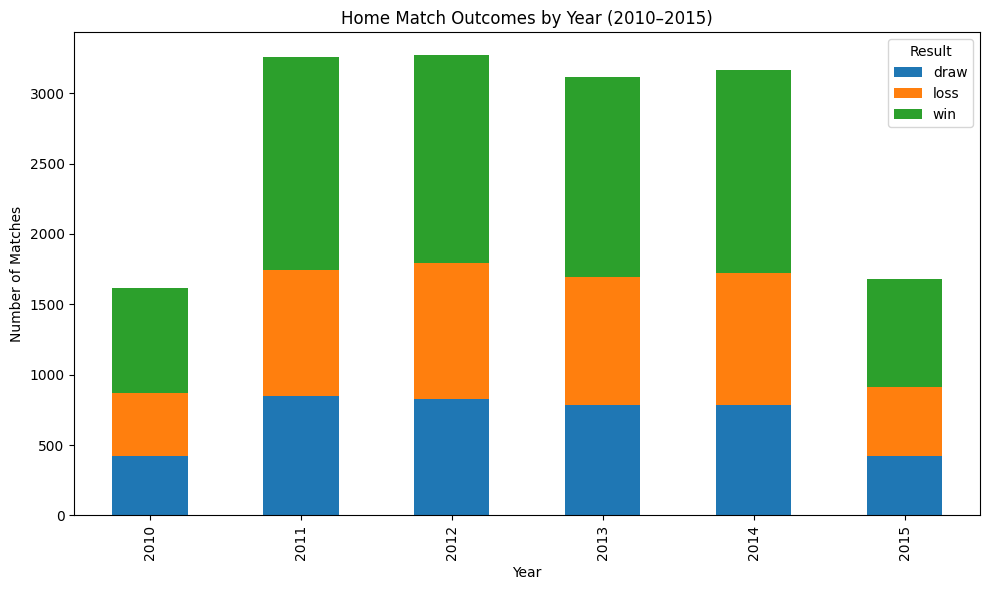

In [4]:

# Question 1: (Before running the code, please be sure that FifaStat file is in the same folder as this file or you may change the address)
import sqlite3
import pandas as pd
import os
import scipy.stats as stats
import matplotlib.pyplot as plt

def analyze_home_field_advantage(db_path):
    conn = sqlite3.connect(db_path, isolation_level=None)

    query = """
    SELECT 
        strftime('%Y', date) as year,
        CASE
            WHEN home_team_goal > away_team_goal THEN 'win'
            WHEN home_team_goal = away_team_goal THEN 'draw'
            ELSE 'loss'
        END as result
    FROM Match
    WHERE season BETWEEN '2010' AND '2015'
    """

    df = pd.read_sql(query, conn, dtype={'year': 'category', 'result': 'category'})
    
    conn.close()
    
    total_games = len(df)
    result_counts = df['result'].value_counts()
    home_wins = result_counts.get('win', 0)
    home_draws = result_counts.get('draw', 0)
    home_losses = result_counts.get('loss', 0)
    
    p_value = stats.binomtest(home_wins, total_games, p=1/3, alternative='greater')
    
    print(f"Home wins: {home_wins}")
    print(f"Home draws: {home_draws}")
    print(f"Home losses: {home_losses}")
    print(f"Total games analyzed: {total_games}")
    print(f"P-value for home win rate being greater than draw or loss: {p_value.pvalue:.4f}")

    yearly_counts = df.groupby(['year', 'result']).size().unstack(fill_value=0)
    yearly_totals = yearly_counts.sum(axis=1)
    win_rate_by_year = yearly_counts.div(yearly_totals, axis=0)
    
    print("\nHome match outcome rates per year (2010-2015):")
    print(win_rate_by_year[['win', 'draw', 'loss']])
    
    print("\nStatistical test: Is home win rate significantly greater than draw or loss?")
    print(f"Home wins: {home_wins} out of {total_games} ({home_wins/total_games:.2%})")
    print(f"Binomial test p-value: {p_value.pvalue:.4f}")

    yearly_counts.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title("Home Match Outcomes by Year (2010–2015)")
    plt.ylabel("Number of Matches")
    plt.xlabel("Year")
    plt.legend(title="Result")
    plt.tight_layout()
    plt.savefig('Home_Match_Outcomes_by_Year.png', dpi=300)
    plt.show()
    
if __name__ == '__main__':
    db_path = "FifaStat.sqlite" #change address here
    if not os.path.exists(db_path):
        print(f"Database file not found: {db_path}")
    else:
        analyze_home_field_advantage(db_path)

Question 2

Question 2: (Before running the code, please be sure that FifaStat file is in the same folder as this file or you may change the address)

Available tables in the database: ['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes']
Player data shape: (11060, 5)
Match data shape: (24755, 27)
Available leagues: ['Belgium Jupiler League', 'England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A', 'Netherlands Eredivisie', 'Poland Ekstraklasa', 'Portugal Liga ZON Sagres', 'Scotland Premier League', 'Spain LIGA BBVA', 'Switzerland Super League']

Analyzing league: Belgium Jupiler League
Number of players with data in Belgium Jupiler League: 1148

Analyzing league: England Premier League
Number of players with data in England Premier League: 1397

Analyzing league: France Ligue 1
Number of players with data in France Ligue 1: 1468

Analyzing league: Germany 1. Bundesliga
Number of players with data in Germany 1. Bundesliga: 1244

Analyzing league: Italy Serie A
Number of players with data in Italy Serie A: 1421

Analyzing league: Netherlands Eredivisie


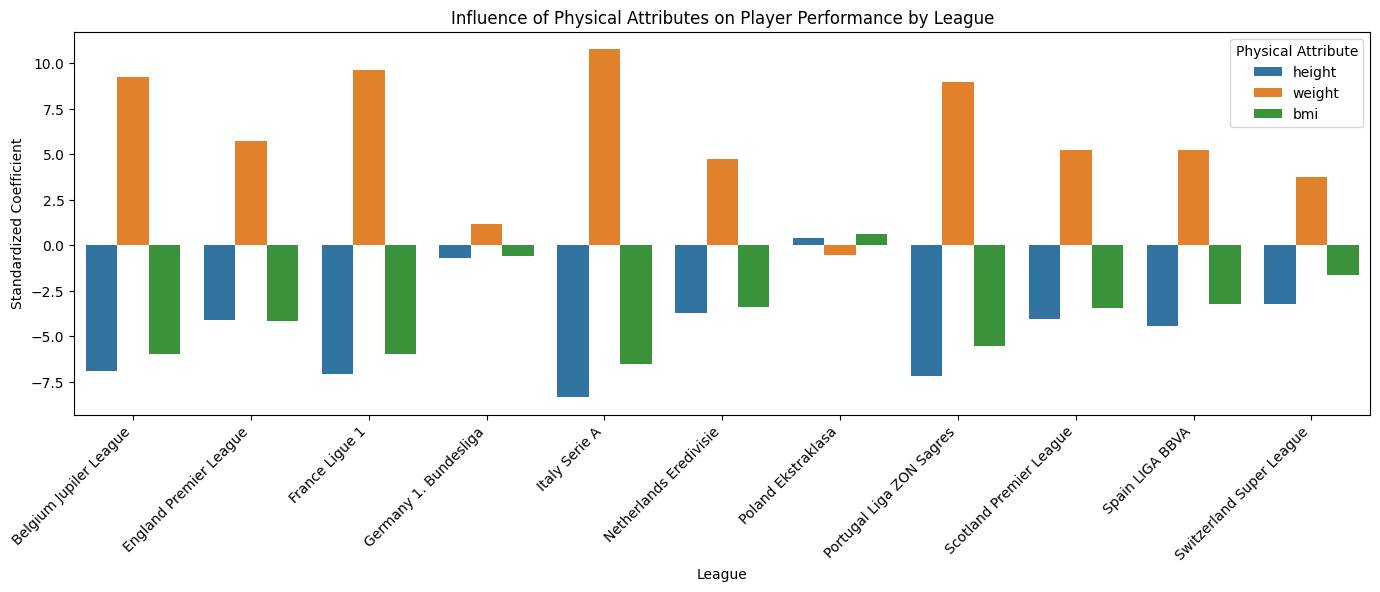


Overall correlation between physical attributes and performance:
overall_rating    1.000000
bmi               0.083664
weight            0.066331
height            0.014232
Name: overall_rating, dtype: float64


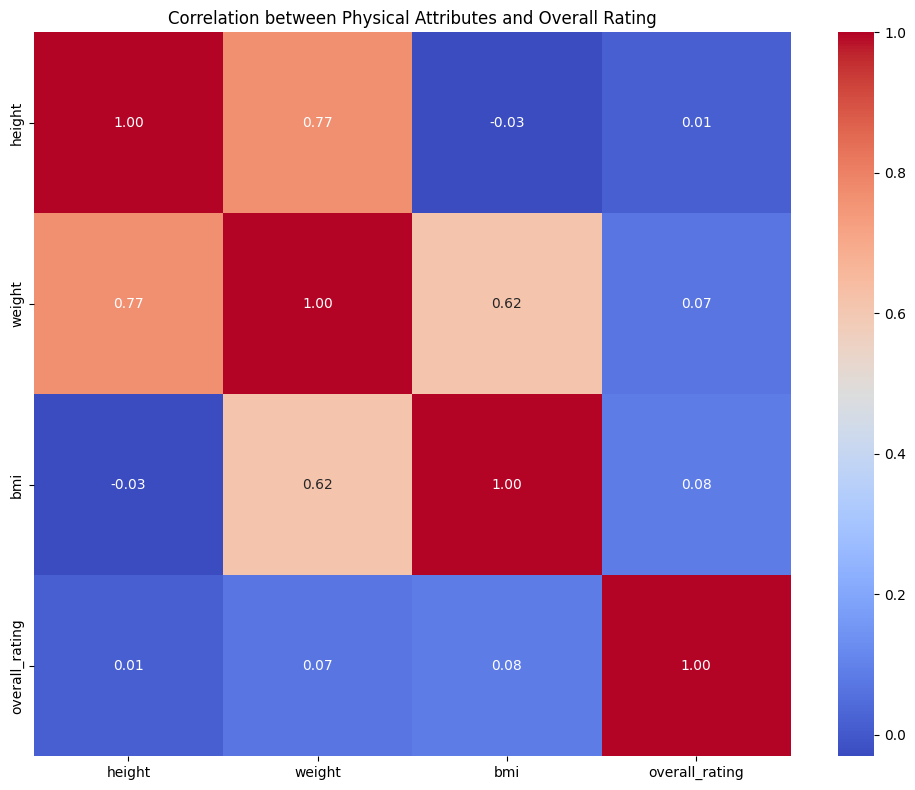


The most important physical attribute overall is: bmi


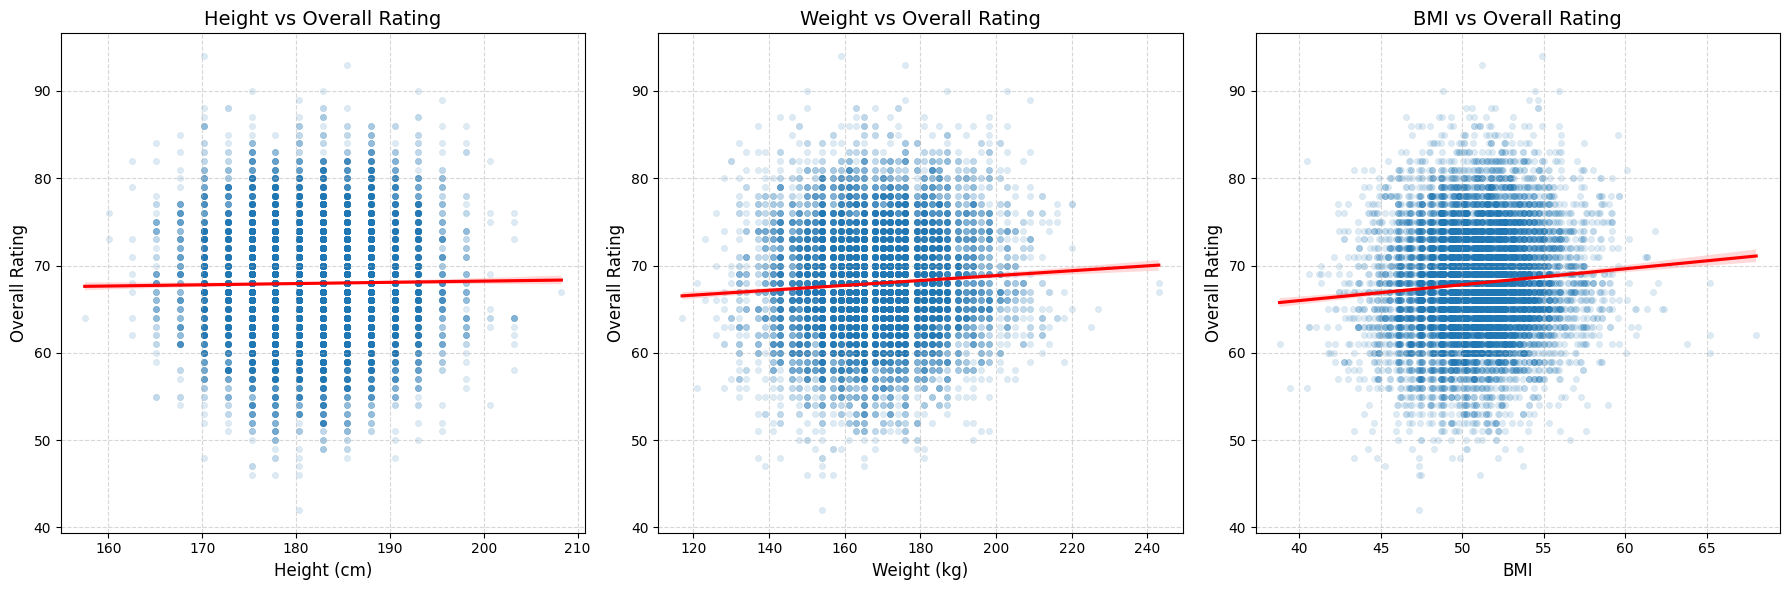


CONCLUSIONS:
1. Overall, bmi shows the strongest relationship with player performance.
2. Physical attributes best predict performance in Italy Serie A (R² = 0.02)
3. Physical attributes least predict performance in Spain LIGA BBVA (R² = 0.00)
4. weight is the most important physical attribute in the highest number of leagues (10 leagues)


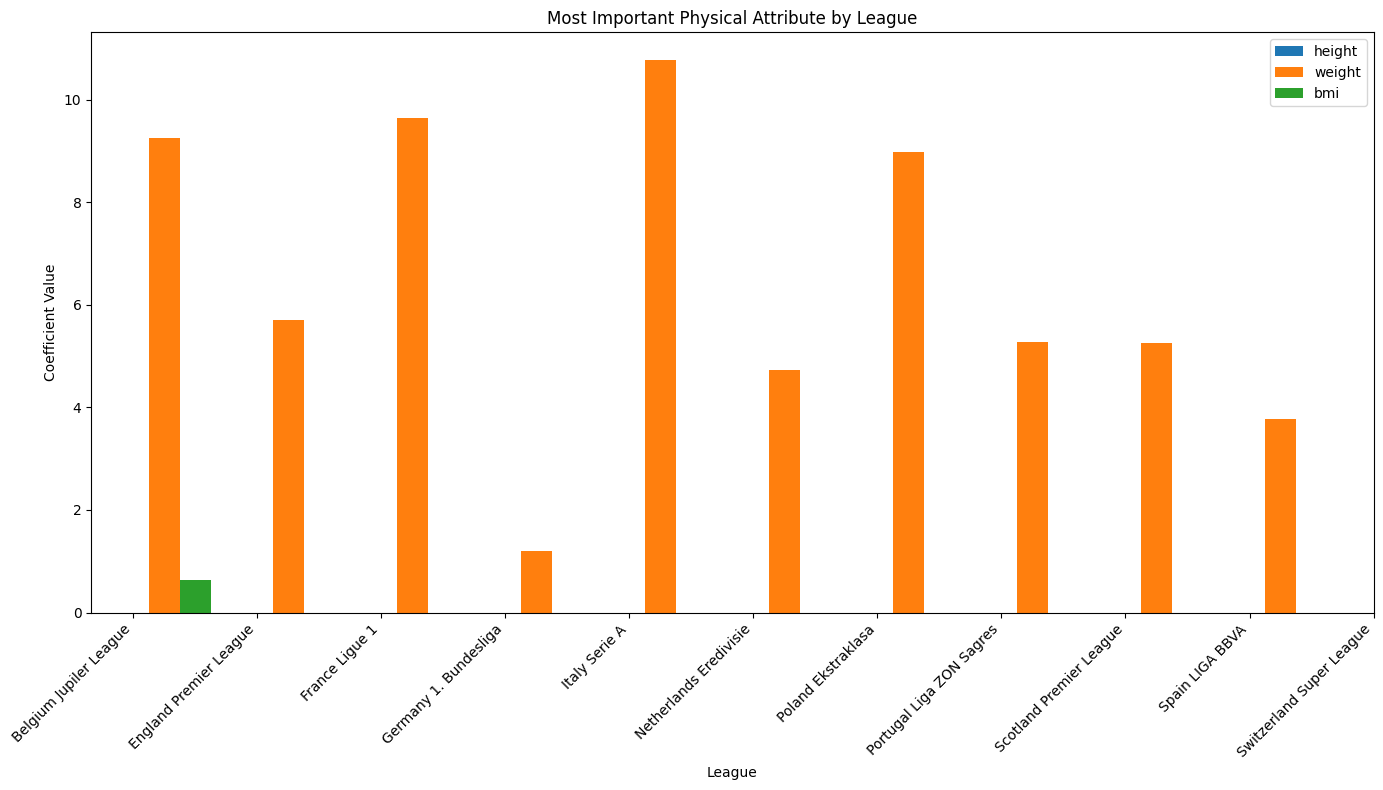

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

conn = sqlite3.connect('FifaStat.sqlite') #change address here, use relative path
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables in the database:", [table[0] for table in tables])

query_player_attributes = """
SELECT 
    player_api_id, 
    height, 
    weight
FROM Player
"""

player_attributes_df = pd.read_sql_query(query_player_attributes, conn)

player_attributes_df['bmi'] = player_attributes_df['weight'] / ((player_attributes_df['height'] / 100) ** 2)

query_player_ratings = """
SELECT 
    player_api_id, 
    overall_rating
FROM Player_Attributes
GROUP BY player_api_id
HAVING MAX(date)
"""

player_ratings_df = pd.read_sql_query(query_player_ratings, conn)

player_data = pd.merge(player_attributes_df, player_ratings_df, on='player_api_id', how='inner')

query_match_data = """
SELECT 
    m.id, 
    m.league_id,
    l.name as league_name,
    m.home_team_goal, 
    m.away_team_goal,
    m.home_player_1, m.home_player_2, m.home_player_3, m.home_player_4, m.home_player_5,
    m.home_player_6, m.home_player_7, m.home_player_8, m.home_player_9, m.home_player_10,
    m.home_player_11, m.away_player_1, m.away_player_2, m.away_player_3, m.away_player_4,
    m.away_player_5, m.away_player_6, m.away_player_7, m.away_player_8, m.away_player_9,
    m.away_player_10, m.away_player_11
FROM Match m
JOIN League l ON m.league_id = l.id
WHERE m.home_player_1 IS NOT NULL  -- Ensure we have player data
"""

match_data_df = pd.read_sql_query(query_match_data, conn)

print(f"Player data shape: {player_data.shape}")
print(f"Match data shape: {match_data_df.shape}")

leagues = match_data_df[['league_id', 'league_name']].drop_duplicates()
print(f"Available leagues: {leagues.league_name.tolist()}")

def analyze_by_league():
    league_results = []
    
    for league_id, league_name in zip(leagues['league_id'], leagues['league_name']):
        print(f"\nAnalyzing league: {league_name}")

        league_matches = match_data_df[match_data_df['league_id'] == league_id]

        player_columns = [col for col in league_matches.columns if 'player' in col and col != 'player_api_id']
        league_players = pd.DataFrame()
        
        for col in player_columns:
            temp_df = league_matches[['id', col]].rename(columns={col: 'player_api_id'})
            temp_df['position'] = col
            temp_df['is_home'] = 'home' in col
            league_players = pd.concat([league_players, temp_df])

        league_players = league_players[league_players['player_api_id'].notnull()]
        league_players['player_api_id'] = league_players['player_api_id'].astype(int)

        league_player_data = pd.merge(league_players, player_data, on='player_api_id', how='inner')
        
        if league_player_data.empty:
            print(f"No player data available for league {league_name}")
            continue

        player_count = league_player_data['player_api_id'].nunique()
        print(f"Number of players with data in {league_name}: {player_count}")

        X = league_player_data[['height', 'weight', 'bmi']]
        y = league_player_data['overall_rating']
        
        if len(X) < 10:
            print(f"Insufficient data for regression analysis in {league_name}")
            continue

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        model = LinearRegression()
        model.fit(X_scaled, y)

        y_pred = model.predict(X_scaled)

        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))

        coef_dict = {
            'league_id': league_id,
            'league_name': league_name,
            'players': player_count,
            'r2': r2,
            'rmse': rmse,
            'height_coef': model.coef_[0],
            'weight_coef': model.coef_[1],
            'bmi_coef': model.coef_[2]
        }
        
        league_results.append(coef_dict)
    
    return pd.DataFrame(league_results)

league_analysis = analyze_by_league()

if not league_analysis.empty:
    print("\nRegression Results by League:")
    print(league_analysis[['league_name', 'players', 'r2', 'height_coef', 'weight_coef', 'bmi_coef']])

    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 2)

    coef_data = pd.melt(
        league_analysis, 
        id_vars=['league_name'], 
        value_vars=['height_coef', 'weight_coef', 'bmi_coef'],
        var_name='attribute',
        value_name='coefficient'
    )

    coef_data['attribute'] = coef_data['attribute'].str.replace('_coef', '')

    sns.barplot(x='league_name', y='coefficient', hue='attribute', data=coef_data)
    plt.title('Influence of Physical Attributes on Player Performance by League')
    plt.ylabel('Standardized Coefficient')
    plt.xlabel('League')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Physical Attribute')
    
    plt.tight_layout()
    plt.show()

    print("\nOverall correlation between physical attributes and performance:")
    correlation = player_data[['height', 'weight', 'bmi', 'overall_rating']].corr()
    print(correlation['overall_rating'].sort_values(ascending=False))

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation between Physical Attributes and Overall Rating')
    plt.tight_layout()
    plt.show()

    attr_importance = correlation['overall_rating'].drop('overall_rating').abs().sort_values(ascending=False)
    most_important = attr_importance.index[0]
    
    print(f"\nThe most important physical attribute overall is: {most_important}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.scatterplot(
        data=player_data,
        x='height',
        y='overall_rating',
        alpha=0.15,
        s=20,
        edgecolor=None,
        ax=axes[0]
    )
    
    sns.regplot(
        data=player_data,
        x='height',
        y='overall_rating',
        scatter=False,
        color='red',
        ax=axes[0]
    )
    
    axes[0].set_title('Height vs Overall Rating', fontsize=14)
    axes[0].set_xlabel('Height (cm)', fontsize=12)
    axes[0].set_ylabel('Overall Rating', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    sns.scatterplot(
        data=player_data,
        x='weight',
        y='overall_rating',
        alpha=0.15,
        s=20,
        edgecolor=None,
        ax=axes[1]
    )
    
    sns.regplot(
        data=player_data,
        x='weight',
        y='overall_rating',
        scatter=False,
        color='red',
        ax=axes[1]
    )
    
    axes[1].set_title('Weight vs Overall Rating', fontsize=14)
    axes[1].set_xlabel('Weight (kg)', fontsize=12)
    axes[1].set_ylabel('Overall Rating', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    sns.scatterplot(
        data=player_data,
        x='bmi',
        y='overall_rating',
        alpha=0.15,
        s=20,
        edgecolor=None,
        ax=axes[2]
    )
    
    sns.regplot(
        data=player_data,
        x='bmi',
        y='overall_rating',
        scatter=False,
        color='red',
        ax=axes[2]
    )
    
    axes[2].set_title('BMI vs Overall Rating', fontsize=14)
    axes[2].set_xlabel('BMI', fontsize=12)
    axes[2].set_ylabel('Overall Rating', fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('physical_attributes_vs_performance.png', dpi=300)
    plt.show()                

    print("\nCONCLUSIONS:")
    print(f"1. Overall, {most_important} shows the strongest relationship with player performance.")

    top_leagues = league_analysis.sort_values('r2', ascending=False)
    if not top_leagues.empty:
        print(f"2. Physical attributes best predict performance in {top_leagues.iloc[0]['league_name']} (R² = {top_leagues.iloc[0]['r2']:.2f})")
        print(f"3. Physical attributes least predict performance in {top_leagues.iloc[-1]['league_name']} (R² = {top_leagues.iloc[-1]['r2']:.2f})")

    league_analysis['most_important'] = league_analysis[['height_coef', 'weight_coef', 'bmi_coef']].abs().idxmax(axis=1)
    league_analysis['most_important'] = league_analysis['most_important'].str.replace('_coef', '')
    
    attribute_counts = league_analysis['most_important'].value_counts()
    most_common_attribute = attribute_counts.index[0] if not attribute_counts.empty else "None"
    
    print(f"4. {most_common_attribute} is the most important physical attribute in the highest number of leagues ({attribute_counts.get(most_common_attribute, 0)} leagues)")

    plt.figure(figsize=(14, 8))
    
    for i, attr in enumerate(['height', 'weight', 'bmi']):
        leagues_with_attr = league_analysis[league_analysis['most_important'] == attr]['league_name'].tolist()
        coef_values = league_analysis[league_analysis['most_important'] == attr][f'{attr}_coef'].tolist()
        
        x_pos = np.arange(len(leagues_with_attr)) + i * 0.25
        plt.bar(x_pos, coef_values, width=0.25, label=attr)
    
    plt.title('Most Important Physical Attribute by League')
    plt.xlabel('League')
    plt.ylabel('Coefficient Value')
    plt.xticks(np.arange(len(league_analysis['league_name'])), league_analysis['league_name'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No leagues with sufficient data for analysis.")

conn.close()

Question 3 

Successfully connected to FifaStat.sqlite
Fetching data from database...
Found 11 leagues
Found 299 teams
Found 25979 matches
Calculating team statistics...
Identifying teams with the best strategies...

Teams with notable strategies:
                 league_name            team_name   strategy  avg_goals_scored  avg_goals_conceded  matches_played
0     Belgium Jupiler League       RSC Anderlecht  Offensive          2.014151            0.858491             212
1     Belgium Jupiler League       RSC Anderlecht  Defensive          2.014151            0.858491             212
2     Belgium Jupiler League       RSC Anderlecht   Balanced          2.014151            0.858491             212
3     England Premier League      Manchester City  Offensive          1.993421            1.009868             304
4     England Premier League    Manchester United  Defensive          1.914474            0.921053             304
5     England Premier League    Manchester United   Balanced          1.914

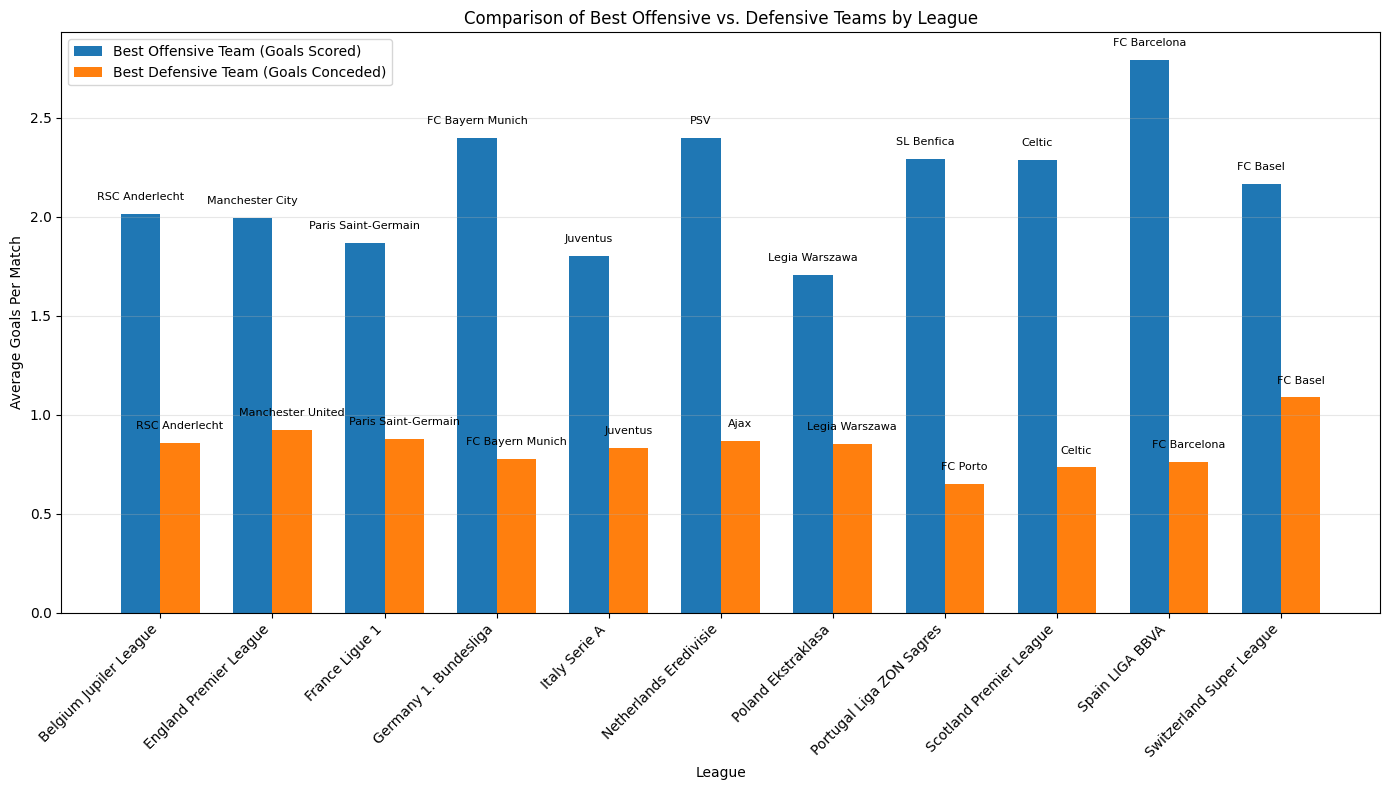

Analysis complete! Check the generated visualizations.


In [6]:
# Question 3: (Before running the code, please be sure that FifaStat file is in the same folder as this file or you may change the address)
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def connect_to_database(db_path):
    """Connect to the SQLite database."""
    try:
        conn = sqlite3.connect(db_path)
        print(f"Successfully connected to {db_path}")
        return conn
    except sqlite3.Error as e:
        print(f"Database connection error: {e}")
        return None

def get_league_data(conn):
    """Get league data from the database."""
    query = """
    SELECT id, name
    FROM League
    """
    return pd.read_sql_query(query, conn)

def get_team_data(conn):
    """Get team data from the database."""
    query = """
    SELECT team_api_id, team_long_name
    FROM Team
    """
    return pd.read_sql_query(query, conn)

def get_match_data(conn):
    """Get match data from the database."""
    query = """
    SELECT 
        league_id,
        home_team_api_id,
        away_team_api_id,
        home_team_goal,
        away_team_goal,
        season
    FROM Match
    """
    return pd.read_sql_query(query, conn)

def calculate_team_stats(match_df, team_df, league_df):
    """Calculate offensive and defensive stats for each team in each league."""
    all_team_stats = []
    
    for league_id in league_df['id'].unique():
        league_matches = match_df[match_df['league_id'] == league_id]
        league_name = league_df[league_df['id'] == league_id]['name'].iloc[0]

        home_teams = league_matches['home_team_api_id'].unique()
        away_teams = league_matches['away_team_api_id'].unique()
        league_teams = np.union1d(home_teams, away_teams)
        
        team_stats = []
        
        for team_id in league_teams:
            team_name = team_df[team_df['team_api_id'] == team_id]['team_long_name'].iloc[0] if len(team_df[team_df['team_api_id'] == team_id]) > 0 else f"Team {team_id}"
            
            home_matches = league_matches[league_matches['home_team_api_id'] == team_id]
            goals_scored_home = home_matches['home_team_goal'].sum()
            goals_conceded_home = home_matches['away_team_goal'].sum()
            matches_home = len(home_matches)

            away_matches = league_matches[league_matches['away_team_api_id'] == team_id]
            goals_scored_away = away_matches['away_team_goal'].sum()
            goals_conceded_away = away_matches['home_team_goal'].sum()
            matches_away = len(away_matches)
            
            total_matches = matches_home + matches_away
            
            if total_matches > 0:
                total_goals_scored = goals_scored_home + goals_scored_away
                total_goals_conceded = goals_conceded_home + goals_conceded_away

                avg_goals_scored = total_goals_scored / total_matches
                avg_goals_conceded = total_goals_conceded / total_matches
                
                goal_difference = total_goals_scored - total_goals_conceded
                
                offensive_rating = avg_goals_scored
                defensive_rating = 1 / (avg_goals_conceded + 0.01) 
                
                team_stats.append({
                    'league_id': league_id,
                    'league_name': league_name,
                    'team_id': team_id,
                    'team_name': team_name,
                    'matches_played': total_matches,
                    'goals_scored': total_goals_scored,
                    'goals_conceded': total_goals_conceded,
                    'avg_goals_scored': avg_goals_scored,
                    'avg_goals_conceded': avg_goals_conceded,
                    'goal_difference': goal_difference,
                    'offensive_rating': offensive_rating,
                    'defensive_rating': defensive_rating
                })
        
        all_team_stats.extend(team_stats)
    
    return pd.DataFrame(all_team_stats)

def identify_strategy_teams(team_stats_df):
    """Identify teams with the best offensive and defensive strategies in each league."""
    strategy_teams = []
    
    for league_name in team_stats_df['league_name'].unique():
        league_data = team_stats_df[team_stats_df['league_name'] == league_name]

        min_matches = league_data['matches_played'].quantile(0.5)
        filtered_league_data = league_data[league_data['matches_played'] >= min_matches]

        best_offensive = filtered_league_data.loc[filtered_league_data['avg_goals_scored'].idxmax()]

        best_defensive = filtered_league_data.loc[filtered_league_data['avg_goals_conceded'].idxmin()]

        best_balanced = filtered_league_data.loc[filtered_league_data['goal_difference'].idxmax()]
        
        strategy_teams.extend([
            {
                'league_name': league_name,
                'team_name': best_offensive['team_name'],
                'strategy': 'Offensive',
                'avg_goals_scored': best_offensive['avg_goals_scored'],
                'avg_goals_conceded': best_offensive['avg_goals_conceded'],
                'matches_played': best_offensive['matches_played']
            },
            {
                'league_name': league_name,
                'team_name': best_defensive['team_name'],
                'strategy': 'Defensive',
                'avg_goals_scored': best_defensive['avg_goals_scored'],
                'avg_goals_conceded': best_defensive['avg_goals_conceded'],
                'matches_played': best_defensive['matches_played']
            },
            {
                'league_name': league_name,
                'team_name': best_balanced['team_name'],
                'strategy': 'Balanced',
                'avg_goals_scored': best_balanced['avg_goals_scored'],
                'avg_goals_conceded': best_balanced['avg_goals_conceded'],
                'matches_played': best_balanced['matches_played']
            }
        ])
    
    return pd.DataFrame(strategy_teams)

def visualize_strategy_comparison(strategy_teams_df):
    """Create a visualization comparing offensive vs defensive strategies across leagues."""
    plt.figure(figsize=(14, 8))

    strategy_df = strategy_teams_df[strategy_teams_df['strategy'].isin(['Offensive', 'Defensive'])]

    leagues = strategy_df['league_name'].unique()
    x = np.arange(len(leagues))
    width = 0.35

    offensive_data = strategy_df[strategy_df['strategy'] == 'Offensive']
    defensive_data = strategy_df[strategy_df['strategy'] == 'Defensive']

    plt.bar(x - width/2, offensive_data['avg_goals_scored'], width, label='Best Offensive Team (Goals Scored)')
    plt.bar(x + width/2, defensive_data['avg_goals_conceded'], width, label='Best Defensive Team (Goals Conceded)')
    
    plt.xlabel('League')
    plt.ylabel('Average Goals Per Match')
    plt.title('Comparison of Best Offensive vs. Defensive Teams by League')
    plt.xticks(x, leagues, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    for i, league in enumerate(leagues):
        off_team = offensive_data[offensive_data['league_name'] == league]['team_name'].iloc[0]
        def_team = defensive_data[defensive_data['league_name'] == league]['team_name'].iloc[0]
        
        off_goals = offensive_data[offensive_data['league_name'] == league]['avg_goals_scored'].iloc[0]
        def_goals = defensive_data[defensive_data['league_name'] == league]['avg_goals_conceded'].iloc[0]
        
        plt.annotate(f"{off_team}", (i - width/2, off_goals), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        plt.annotate(f"{def_team}", (i + width/2, def_goals), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    plt.savefig("strategy_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def main():
    db_path = "FifaStat.sqlite" #change address here

    conn = connect_to_database(db_path)
    if conn is None:
        print("Failed to connect to database.")
        return

    print("Fetching data from database...")
    league_df = get_league_data(conn)
    team_df = get_team_data(conn)
    match_df = get_match_data(conn)
    
    print(f"Found {len(league_df)} leagues")
    print(f"Found {len(team_df)} teams")
    print(f"Found {len(match_df)} matches")
    
    print("Calculating team statistics...")
    team_stats_df = calculate_team_stats(match_df, team_df, league_df)

    print("Identifying teams with the best strategies...")
    strategy_teams_df = identify_strategy_teams(team_stats_df)
    print("\nTeams with notable strategies:")
    print(strategy_teams_df.to_string())

    print("Creating strategy comparison visualization...")
    visualize_strategy_comparison(strategy_teams_df)
    
    print("Analysis complete! Check the generated visualizations.")
    
    conn.close()

if __name__ == "__main__":
    main()
